# **Resume Ranking & Candidate Shortlisting System**

### *Project Description*

This project builds a machine learning system that automatically ranks resumes and shortlists candidates based on their qualifications, skills, and experience using natural language processing and classification models.

### *Problem Statement*

Manually reviewing thousands of resumes is time-consuming and inconsistent—this system aims to automate the process by evaluating and ranking resumes based on relevance to job requirements.

### *Import Libraries*

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### *Load dataset*

In [ ]:
df = pd.read_csv("resume_data.csv")

In [ ]:
df.head()

,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,...,positions,locations,responsibilities,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],...,['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaborat...,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,,Technical Support\nTroubleshooting\nCollaborat...,,0.850000
1,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],...,['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional ...,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),,Machine Learning Leadership\nCross-Functional ...,,0.750000
2,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],...,['Software Developer (Machine Learning Enginee...,['N/A'],"Trade Marketing Executive\nBrand Visibility, S...","Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667
3,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...","[None, None, None, None, None, None]","['January 2011', 'January 2008', 'January 2006...",...,"['Accountant', 'Accounts Receivable Clerk', 'M...","['City, State', 'City, State', 'City, State', ...",Apparel Sourcing\nQuality Garment Sourcing\nRe...,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000
4,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...","[None, None, None, None, None]","['January 2016', 'January 2016', 'January 2012...",...,"['Staff Accountant', 'Senior Accountant', 'Tax...","['City, State', 'City, State', 'City, State', ...",iOS Lifecycle\nRequirement Analysis\nNative Fr...,Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000


In [ ]:
df.describe()

,matched_score
count,9544.000000
mean,0.660831
std,0.167040
min,0.000000
25%,0.583333
50%,0.683333
75%,0.793333
max,0.970000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   skills                        9544 non-null   object 
 1   educational_institution_name  9544 non-null   object 
 2   degree_names                  9544 non-null   object 
 3   passing_years                 9544 non-null   object 
 4   educational_results           9544 non-null   object 
 5   result_types                  9544 non-null   object 
 6   major_field_of_studies        9544 non-null   object 
 7   professional_company_names    9544 non-null   object 
 8   company_urls                  9544 non-null   object 
 9   start_dates                   9544 non-null   object 
 10  end_dates                     9544 non-null   object 
 11  related_skils_in_job          9544 non-null   object 
 12  positions                     9544 non-null   object 
 13  loc

## DATA PREPROCESSING

### *Drop Columns with More Than 50% Missing Values*

In [ ]:
df_clean = df.dropna(thresh=len(df) * 0.5, axis=1)

### *Fill Remaining Missing Values*

In [ ]:
df_clean.fillna("", inplace=True)

### *Drop Irrelevant or Redundant Columns (if any)*

In [ ]:
df_clean.drop(columns=['address', 'responsibilities.1'], inplace=True, errors='ignore')

### *Combine Relevant Text Columns into One*

In [ ]:
text_cols = [
    'skills', 'degree_names', 'major_field_of_studies',
    'responsibilities', 'skills_required'
]

df_clean['combined_text'] = df_clean[text_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

### *Text Cleaning Function*

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    return text.strip()

df_clean['cleaned_text'] = df_clean['combined_text'].apply(clean_text)

### *Handle Outliers in Target Column 'matched_score'*

In [ ]:
Q1 = df_clean['matched_score'].quantile(0.25)
Q3 = df_clean['matched_score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean['matched_score'] = df_clean['matched_score'].apply(lambda x: max(min(x, upper_bound), lower_bound))

### *Distribution of Resume Scores*

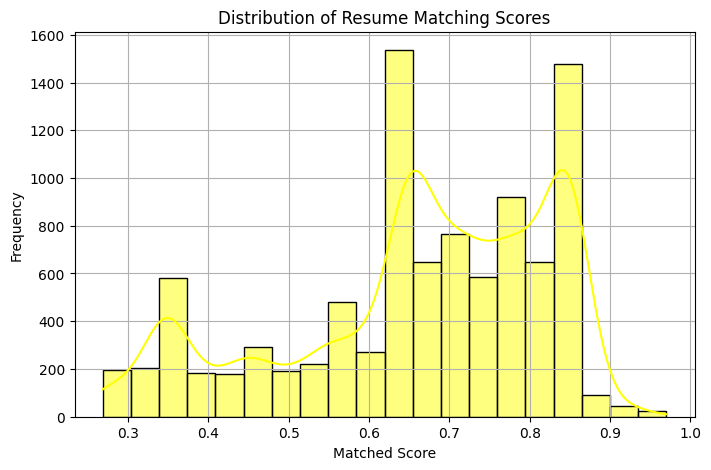

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df_clean['matched_score'], bins=20, kde=True, color='yellow')
plt.title("Distribution of Resume Matching Scores")
plt.xlabel("Matched Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## FEATURE ENGINEERING

### *Clean and combine the skills column*

In [ ]:
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### *Convert stringified list to actual Python list*

In [ ]:
df_clean = df.copy()

def safe_parse_skills(skill_str):
    try:
        return ast.literal_eval(skill_str)
    except (ValueError, SyntaxError):
        return []  # return empty list if parsing fails

# Apply safe parsing
df_clean['skills'] = df_clean['skills'].fillna('[]').apply(safe_parse_skills)

### *Flatten all skills into one list*

In [ ]:
all_skills_flat = [skill.strip().lower() for sublist in df_clean['skills'].dropna() for skill in sublist if skill.strip()]

### *Count top skills*



In [ ]:
skill_counts = Counter(all_skills_flat)
top_skills = pd.DataFrame(skill_counts.most_common(20), columns=['Skill', 'Count'])

### *Bar Plot for Top 20 Skills*

<ipython-input-50-7a78ef0e3253>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=top_skills, palette='coolwarm')
<ipython-input-50-7a78ef0e3253>:6: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


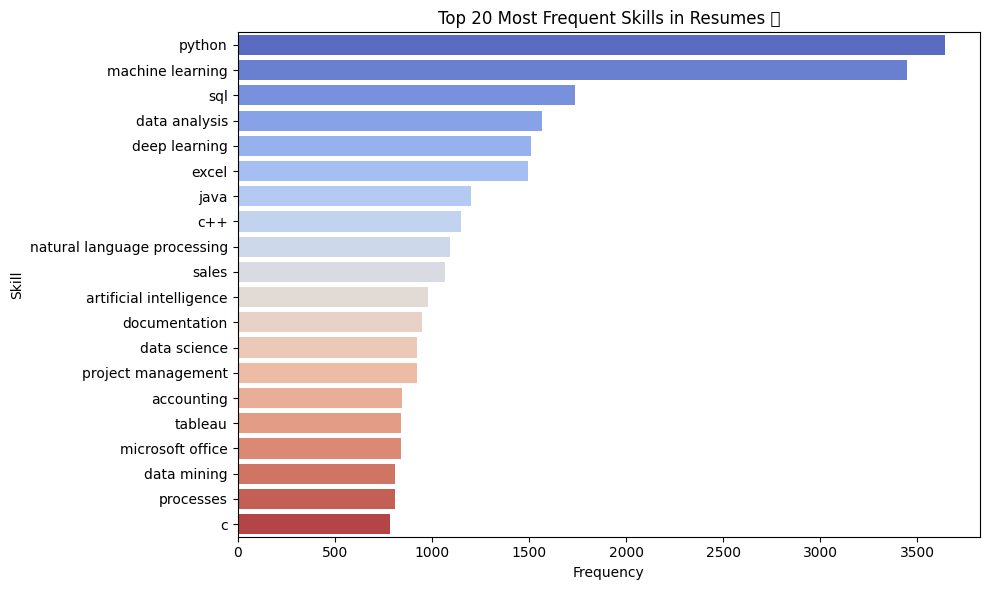

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Skill', data=top_skills, palette='coolwarm')
plt.title('Top 20 Most Frequent Skills in Resumes 🔝')
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

### *Word Cloud of Skills*

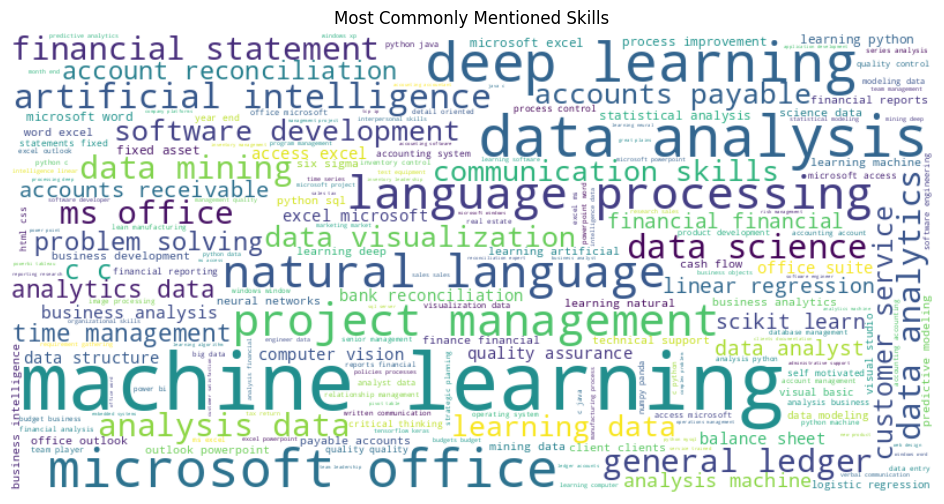

In [ ]:
text_skills = ' '.join(all_skills_flat)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_skills)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Commonly Mentioned Skills")
plt.show()

## FEATURE EXTRACTION

### *Convert Cleaned Text into TF-IDF Vectors*

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_clean['cleaned_text']).toarray()

### *Target Variable*

In [ ]:
y = df_clean['matched_score']

## TRAIN-TEST SPLIT

### *Split Data into Train and Test Sets*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## MODEL TRAINING

### *Train RandomForestRegressor Model*

In [ ]:
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

### *Experience vs Matched Score*

#### Extract Numeric Experience (in years)

In [ ]:
import re

def extract_years(text):
    if isinstance(text, str):
        match = re.search(r'(\d+)', text)
        return int(match.group(1)) if match else None
    return None

df_clean['experience'] = df_clean['experiencere_requirement'].apply(extract_years)

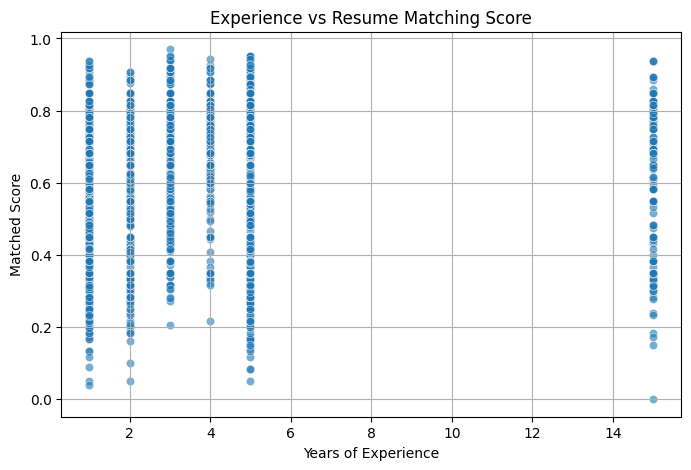

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='experience', y='matched_score', data=df_clean, alpha=0.6)
plt.title("Experience vs Resume Matching Score")
plt.xlabel("Years of Experience")
plt.ylabel("Matched Score")
plt.grid(True)
plt.show()

## MODEL EVALUATION

### *Make Predictions*

In [ ]:
y_pred = model.predict(X_test)

### *Evaluate Model Performance*

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.011617604906117539
R^2 Score: 0.5680636540708293


## VISUALIZATION

### *Actual vs Predicted Plot*

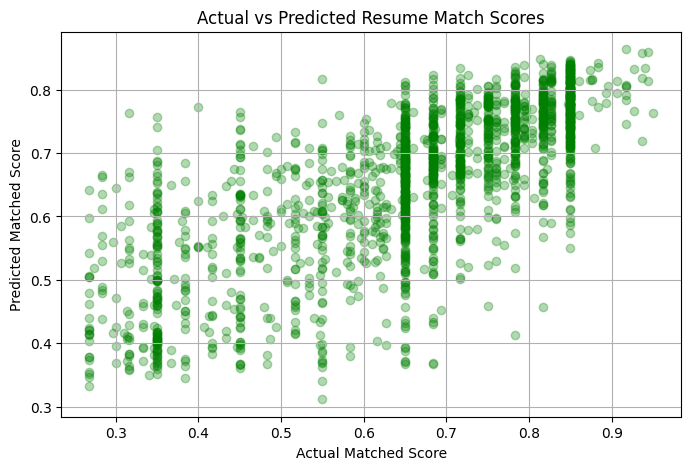

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3, color='green')
plt.xlabel("Actual Matched Score")
plt.ylabel("Predicted Matched Score")
plt.title("Actual vs Predicted Resume Match Scores")
plt.grid(True)
plt.show()

### *Visualize Top 20 Important Features (Words)*

<ipython-input-41-3440ca435e9a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


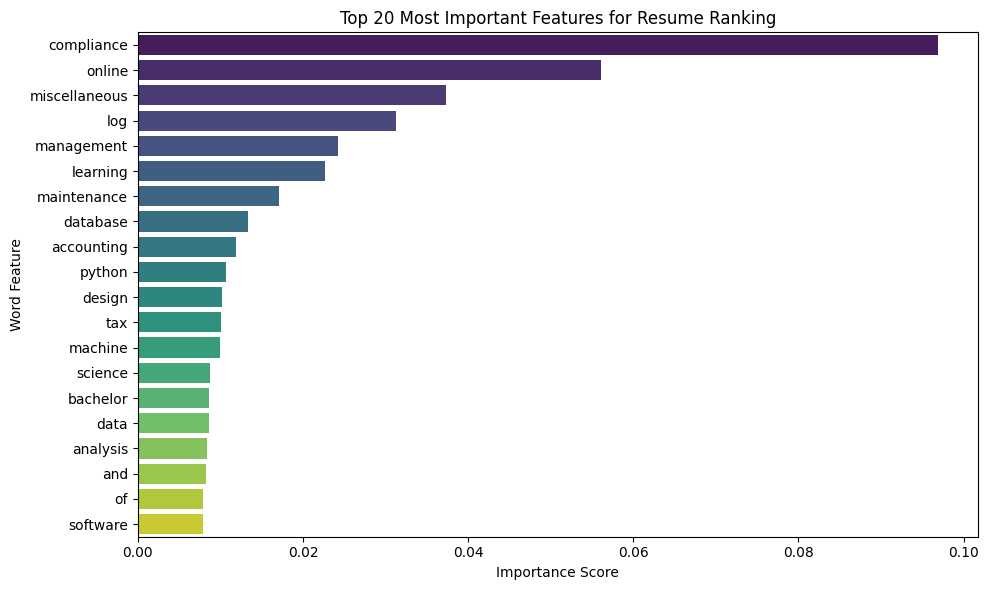

In [ ]:
importances = model.feature_importances_
feature_names = tfidf.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 20 Most Important Features for Resume Ranking")
plt.xlabel("Importance Score")
plt.ylabel("Word Feature")
plt.tight_layout()
plt.show()